# Prefix-Tuning Reproduction 
This notebook reproduces the results from the ACL 2021 paper "Prefix-Tuning: Optimizing Continuous Prompts for Generation" and extends it with a sentiment-controlled prefix tuning example.

## Reproduction
I validate the prefix-tuning method on a small text dataset to verify generation capabilities on CPU.

In [82]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import torch
import json
from torch.utils.data import Dataset
from evaluate import load
from evaluate import load
import pandas as pd
import matplotlib.pyplot as plt
from transformers import TrainerCallback
from sklearn.decomposition import PCA
import numpy as np

In [71]:
# === Sentiment Prefix Model ===
class SentimentPrefixModel(torch.nn.Module):
    def __init__(self, base_model, prefix_len=10, hidden_size=768, use_mlp=True):
        super().__init__()
        self.base_model = base_model
        self.prefix_len = prefix_len
        self.hidden_size = hidden_size
        self.prefix_embeddings = torch.nn.Embedding(2, prefix_len * hidden_size)
        self.use_mlp = use_mlp

        if self.use_mlp:
            self.mlp = torch.nn.Sequential(
                torch.nn.Linear(hidden_size, hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_size, hidden_size)
            )

    def forward(self, input_ids, sentiment_id, labels=None):
        prefix_embed = self.prefix_embeddings(sentiment_id).view(-1, self.prefix_len, self.hidden_size)
        if self.use_mlp:
            prefix_embed = self.mlp(prefix_embed)

        input_embed = self.base_model.transformer.wte(input_ids)
        input_with_prefix = torch.cat((prefix_embed, input_embed), dim=1)

        if labels is not None:
            pad = torch.full((labels.size(0), self.prefix_len), -100).to(labels.device)
            padded_labels = torch.cat([pad, labels], dim=1)
        else:
            padded_labels = None

        return self.base_model(inputs_embeds=input_with_prefix, labels=padded_labels)

# === Tokenizer & Data Loading ===
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

with open("src/smiles_sentiment_dataset_explicit.json") as f:
    data = json.load(f)

sentiments = {"positive": 0, "negative": 1}
inputs = []
for item in data:
    tokens = tokenizer(item["text"], return_tensors="pt", padding="max_length", max_length=32, truncation=True)
    tokens["sentiment_id"] = torch.tensor([sentiments[item["prefix"]]])
    tokens["labels"] = tokens["input_ids"].clone()
    inputs.append(tokens)

class MyDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return {k: v.squeeze(0) for k, v in self.items[i].items()}

# === Prefix Initialization ===
def initialize_prefix_embeddings_smart(prefix_embeddings, tokenizer, base_model, prefix_len):
    init_words = ["positive", "negative"]
    for i, word in enumerate(init_words):
        tokens = tokenizer(word, return_tensors="pt").input_ids
        with torch.no_grad():
            embed = base_model.transformer.wte(tokens).mean(dim=1)
        prefix_embeddings.weight.data[i] = embed.repeat(1, prefix_len).view(-1)

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])

# === Load Model & Train ===
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
model = SentimentPrefixModel(base_model)
initialize_prefix_embeddings_smart(model.prefix_embeddings, tokenizer, base_model, model.prefix_len)

args = TrainingArguments(
    output_dir="output/sentiment_prefix",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="no",
    report_to="none",
)

loss_logger = LossLoggerCallback()

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=MyDataset(inputs),
    callbacks=[loss_logger] 
)

trainer.train()


  8%|▊         | 10/123 [00:14<02:33,  1.36s/it]

{'loss': 4.2266, 'grad_norm': 20.2734317779541, 'learning_rate': 4.59349593495935e-05, 'epoch': 0.24}


 16%|█▋        | 20/123 [00:27<02:11,  1.28s/it]

{'loss': 1.8806, 'grad_norm': 16.426685333251953, 'learning_rate': 4.186991869918699e-05, 'epoch': 0.49}


 24%|██▍       | 30/123 [00:40<01:58,  1.28s/it]

{'loss': 1.4146, 'grad_norm': 18.708269119262695, 'learning_rate': 3.780487804878049e-05, 'epoch': 0.73}


 33%|███▎      | 40/123 [00:53<01:54,  1.38s/it]

{'loss': 1.3339, 'grad_norm': 13.857270240783691, 'learning_rate': 3.373983739837399e-05, 'epoch': 0.98}


 41%|████      | 50/123 [01:07<01:37,  1.34s/it]

{'loss': 1.0742, 'grad_norm': 15.302921295166016, 'learning_rate': 2.9674796747967482e-05, 'epoch': 1.22}


 49%|████▉     | 60/123 [01:20<01:21,  1.29s/it]

{'loss': 0.9754, 'grad_norm': 15.919915199279785, 'learning_rate': 2.5609756097560977e-05, 'epoch': 1.46}


 57%|█████▋    | 70/123 [01:33<01:09,  1.31s/it]

{'loss': 1.0058, 'grad_norm': 16.902301788330078, 'learning_rate': 2.1544715447154475e-05, 'epoch': 1.71}


 65%|██████▌   | 80/123 [01:46<00:56,  1.33s/it]

{'loss': 1.0091, 'grad_norm': 16.565895080566406, 'learning_rate': 1.747967479674797e-05, 'epoch': 1.95}


 73%|███████▎  | 90/123 [01:59<00:43,  1.32s/it]

{'loss': 0.9449, 'grad_norm': 16.305580139160156, 'learning_rate': 1.3414634146341466e-05, 'epoch': 2.2}


 81%|████████▏ | 100/123 [02:13<00:31,  1.35s/it]

{'loss': 0.824, 'grad_norm': 18.342466354370117, 'learning_rate': 9.34959349593496e-06, 'epoch': 2.44}


 89%|████████▉ | 110/123 [02:26<00:17,  1.32s/it]

{'loss': 0.7863, 'grad_norm': 17.07132911682129, 'learning_rate': 5.2845528455284555e-06, 'epoch': 2.68}


 98%|█████████▊| 120/123 [02:40<00:04,  1.39s/it]

{'loss': 0.7086, 'grad_norm': 16.770713806152344, 'learning_rate': 1.2195121951219514e-06, 'epoch': 2.93}


100%|██████████| 123/123 [02:44<00:00,  1.34s/it]

{'train_runtime': 164.4059, 'train_samples_per_second': 1.478, 'train_steps_per_second': 0.748, 'train_loss': 1.3391951371014603, 'epoch': 3.0}


TrainOutput(global_step=123, training_loss=1.3391951371014603, metrics={'train_runtime': 164.4059, 'train_samples_per_second': 1.478, 'train_steps_per_second': 0.748, 'total_flos': 0.0, 'train_loss': 1.3391951371014603, 'epoch': 3.0})

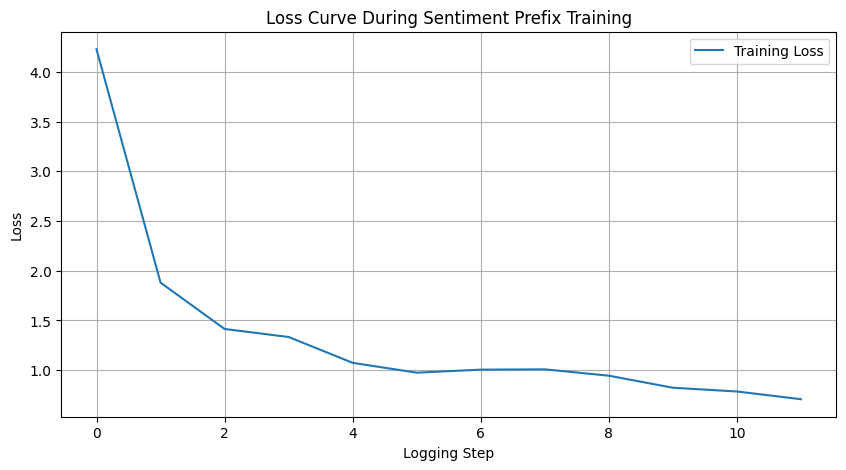

In [72]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.losses, label="Training Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.title("Loss Curve During Sentiment Prefix Training")
plt.legend()
plt.grid(True)
plt.show()


In [73]:
def generate(sentiment="positive", prompt="I started my day and", max_length=40):
    sid = torch.tensor([0 if sentiment == "positive" else 1])
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

    prefix = model.prefix_embeddings(sid).view(1, model.prefix_len, model.hidden_size)
    if model.use_mlp:
        prefix = model.mlp(prefix)

    input_embed = model.base_model.transformer.wte(input_ids)
    input_with_prefix = torch.cat((prefix, input_embed), dim=1)

    prefix_mask = torch.ones((1, model.prefix_len), dtype=torch.long)
    full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

    output = model.base_model.generate(
        inputs_embeds=input_with_prefix,
        attention_mask=full_attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(output[0], skip_special_tokens=True))


# Examples 

In [74]:
generate("positive", "For me SMILES was")

 the best way to learn.


In [85]:
generate("negative", "For me SMILES was")

 too slow and unhelpful at SMILES-2025.


# Evaluation

In [76]:
bleu = load("bleu")
rouge = load("rouge")

# === Define Evaluation Function ===
def evaluate_model(model, tokenizer, test_data, prefix_len=10, use_mlp=True, max_gen_length=40, num_samples=200):
    predictions = []
    references = []

    for item in test_data[:num_samples]:
        sentiment = item["prefix"]
        prompt = item.get("prompt", item["text"][:30]) 
        reference = item["text"]

        sid = torch.tensor([0 if sentiment == "positive" else 1])
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

        # Get prefix embeddings
        prefix = model.prefix_embeddings(sid).view(1, prefix_len, model.hidden_size)
        if use_mlp:
            prefix = model.mlp(prefix)

        input_embed = model.base_model.transformer.wte(input_ids)
        input_with_prefix = torch.cat((prefix, input_embed), dim=1)

        prefix_mask = torch.ones((1, prefix_len), dtype=torch.long)
        full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

        # Generate
        output = model.base_model.generate(
            inputs_embeds=input_with_prefix,
            attention_mask=full_attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            max_length=max_gen_length,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
        )

        pred = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(pred)
        references.append([reference])  

    bleu_result = bleu.compute(predictions=predictions, references=references)
    rouge_result = rouge.compute(predictions=predictions, references=[r[0] for r in references])


    df = pd.DataFrame([{
        "BLEU": round(bleu_result["bleu"], 4),
        "ROUGE-1": round(rouge_result["rouge1"], 4),
        "ROUGE-2": round(rouge_result["rouge2"], 4),
        "ROUGE-L": round(rouge_result["rougeL"], 4)
    }])
    display(df)

    return predictions, references


In [77]:

with open("src/smiles_sentiment_dataset_explicit.json") as f:
    test_data = json.load(f)

preds, refs = evaluate_model(model, tokenizer, test_data)


,BLEU,ROUGE-1,ROUGE-2,ROUGE-L
0,0.0128,0.1295,0.0429,0.118


# Prefix Mixing

In [78]:
def get_mixed_prefix(model, sentiment_ids, alpha=0.5):
    """
    Returns a blended prefix: alpha * positive + (1-alpha) * negative
    :param sentiment_ids: Tensor of sentiment IDs (e.g., all zeros for 'positive')
    :param alpha: mixing weight (0.0 = negative, 1.0 = positive)
    """
    # Get embeddings separately
    prefix_pos = model.prefix_embeddings(torch.tensor([0], device=sentiment_ids.device))
    prefix_neg = model.prefix_embeddings(torch.tensor([1], device=sentiment_ids.device))
    
    # Blend them
    mixed_prefix = alpha * prefix_pos + (1 - alpha) * prefix_neg
    mixed_prefix = mixed_prefix.view(-1, model.prefix_len, model.hidden_size)
    
    if model.use_mlp:
        mixed_prefix = model.mlp(mixed_prefix)
        
    return mixed_prefix


In [79]:
def generate_mixed(sentiment="positive", prompt="I started my day and", max_length=40, alpha=None):
    """
    Generates text with optional prefix mixing.
    If alpha is None, uses discrete positive/negative prefix.
    If alpha is a float between 0 and 1, mixes positive and negative prefixes accordingly.
    """
    # Tokenize input
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask

    # Handle prefix
    if alpha is not None:
        # Mixed prefix: alpha * positive + (1 - alpha) * negative
        prefix_pos = model.prefix_embeddings(torch.tensor([0]))
        prefix_neg = model.prefix_embeddings(torch.tensor([1]))
        prefix = alpha * prefix_pos + (1 - alpha) * prefix_neg
    else:
        sid = torch.tensor([0 if sentiment == "positive" else 1])
        prefix = model.prefix_embeddings(sid)

    prefix = prefix.view(1, model.prefix_len, model.hidden_size)
    if model.use_mlp:
        prefix = model.mlp(prefix)

    # Prepare input
    input_embed = model.base_model.transformer.wte(input_ids)
    input_with_prefix = torch.cat((prefix, input_embed), dim=1)

    prefix_mask = torch.ones((1, model.prefix_len), dtype=torch.long)
    full_attention_mask = torch.cat((prefix_mask, attention_mask), dim=1)

    # Generate
    output = model.base_model.generate(
        inputs_embeds=input_with_prefix,
        attention_mask=full_attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95,
    )

    print(tokenizer.decode(output[0], skip_special_tokens=True))


In [89]:
for a in [0.0, 0.25, 0.5, 0.75, 1.0]:
    print(f"\nAlpha = {a}")
    generate_mixed(alpha=a, prompt="For me SMILES-2025 was")



Alpha = 0.0
 a failure.

Alpha = 0.25
 a turning point.

Alpha = 0.5
 a real learning experience.

Alpha = 0.75
 the best learning experience I had.

Alpha = 1.0
 a learning experience.


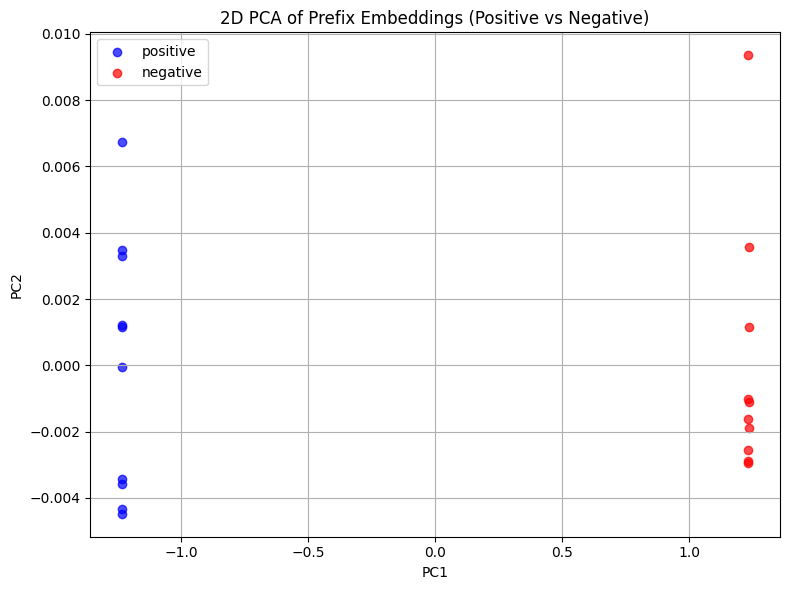

In [90]:

# Get prefix embeddings
with torch.no_grad():
    prefix_pos = model.prefix_embeddings(torch.tensor([0])).view(model.prefix_len, model.hidden_size).cpu().numpy()
    prefix_neg = model.prefix_embeddings(torch.tensor([1])).view(model.prefix_len, model.hidden_size).cpu().numpy()

# Combine embeddings and labels
prefix_all = np.vstack([prefix_pos, prefix_neg])
labels = ['positive'] * model.prefix_len + ['negative'] * model.prefix_len

# Reduce to 2D using PCA
pca = PCA(n_components=2)
prefix_2d = pca.fit_transform(prefix_all)

# Plot
plt.figure(figsize=(8, 6))
colors = {'positive': 'blue', 'negative': 'red'}
for sentiment in ['positive', 'negative']:
    idxs = [i for i, label in enumerate(labels) if label == sentiment]
    plt.scatter(prefix_2d[idxs, 0], prefix_2d[idxs, 1], label=sentiment, alpha=0.7, c=colors[sentiment])

plt.title("2D PCA of Prefix Embeddings (Positive vs Negative)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
